In [11]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from util.preprocessing import *
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import OneSidedSelection, EditedNearestNeighbours
import re
from dateutil import parser


def preprocess_data():
    df = pd.read_csv('../data/merge_output-v2.csv', encoding='ANSI')
    #필요 없는 특성 제거

    allColumns = df.columns
    params = ['발생일시','공공/민간 구분', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '공사비', '공사기간', '공정률', '작업자수', '설계안전성검토', '공종']

    df = df.drop(allColumns.drop(params), axis=1)

    df = df.dropna()

    df['공종'] = df['공종'].apply(extract_middle_class)

    print(df['공종'].value_counts())

    #범주형 데이터를 수치형 데이터로 인코딩

    df['사망자수(명)'] = df['사망자수(명)'].apply(parse_num_of_people)
    df['부상자수(명)'] = df['부상자수(명)'].apply(parse_num_of_people)
    df['발생일시'] = df['발생일시'].apply(extract_month)
    df['시설물 종류'] = df['시설물 종류'].apply(extract_facility)
    df['공사기간'] = df['공사기간'].apply(count_days)
    df['공정률'] = df['공정률'].apply(str_to_median)
    df['작업자수'] = df['작업자수'].apply(extract_population)
    df['공사비'] = df['공사비'].apply(extract_cost)
    safety_ratio_by_job = calculate_safety_ratios(df)
    safety_ratio_by_job = safety_ratio_by_job.drop(['공종별 안전사고 발생 비율', '공종별 사망자 비율', '공종별 부상자 비율', '공종별 안전사고 발생강도 비율', '공종별 안전사고 발생 건수', '공종별 사망자수', '공종별 부상자수'], axis=1)
    df = pd.merge(df, safety_ratio_by_job, on='공종', how='inner')
    df['피해규모'] = df.apply(calc_damage_scale, axis=1)

    # 기상 상태 컬럼 분리
    df[['날씨', '기온', '습도']] = df['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
    df = df.drop(['기상상태'], axis=1)

    df = df.dropna()

    le = LabelEncoder()
    df['설계안전성검토'] = le.fit_transform(df['설계안전성검토'])

    # 시설물 종류 특성을 원-핫 인코딩

    ct = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse=False), ['시설물 종류', '공공/민간 구분', '날씨', '공종'])], remainder='passthrough'
    )
    ct.fit(df)
    X = ct.transform(df)
    # 컬럼 이름 리스트 생성

    num_cols = df.columns.tolist()
    ohe = ct.named_transformers_['onehot']
    ohe_cols = ohe.get_feature_names_out(['시설물 종류', '공공/민간 구분', '날씨', '공종']).tolist()
    new_cols = ohe_cols + num_cols
    new_cols.remove('시설물 종류')
    new_cols.remove('공공/민간 구분')
    new_cols.remove('날씨')
    new_cols.remove('공종')
    # DataFrame으로 변환

    df = pd.DataFrame(X, columns=new_cols)

    df = df.astype('float64')

    df['습도'] = df['습도'].apply(lambda x: x/100)

    # --------------------정제 완료 ----------------------------

    X = df.drop(['사망자수(명)', '부상자수(명)', '피해규모', '공종별 위험도 평가지수'], axis=1)
    y = df[['공종별 위험도 평가지수']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

preprocess_data()

C:\Users\추효정\AppData\Local\Temp\ipykernel_30028\1250896495.py:17: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/merge_output-v2.csv', encoding='ANSI')


공종
건축      10498
토목       3988
기타       1787
기계설비      765
전기설비      440
산업설비      278
통신설비        7
Name: count, dtype: int64
float64
/n/n


c:\Users\추효정\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(       시설물 종류_건축   시설물 종류_산업환경설비   시설물 종류_조경   시설물 종류_토목   공공/민간 구분_공공   
 2656          1.0             0.0         0.0         0.0          1.0  \
 13271         1.0             0.0         0.0         0.0          1.0   
 1934          1.0             0.0         0.0         0.0          0.0   
 9263          0.0             0.0         0.0         1.0          0.0   
 8629          0.0             0.0         0.0         1.0          1.0   
 ...           ...             ...         ...         ...          ...   
 5191          1.0             0.0         0.0         0.0          1.0   
 13418         0.0             1.0         0.0         0.0          1.0   
 5390          1.0             0.0         0.0         0.0          1.0   
 860           1.0             0.0         0.0         0.0          1.0   
 7270          1.0             0.0         0.0         0.0          0.0   
 
        공공/민간 구분_민간  날씨_강설  날씨_강우  날씨_강풍  날씨_맑음  ...  공종_토목  공종_통신설비  발생일시   
 2656           0.0 

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# 데이터 분리
X_train, X_test, y_train, y_test = preprocess_data()

# 모델 초기화
lr_model = LinearRegression()

# 모델 학습
lr_model.fit(X_train, y_train)

# 예측 수행
y_pred = lr_model.predict(X_test)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

C:\Users\추효정\AppData\Local\Temp\ipykernel_30028\286497571.py:17: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/merge_output-v2.csv', encoding='ANSI')


공종
건축      10498
토목       3988
기타       1787
기계설비      765
전기설비      440
산업설비      278
통신설비        7
Name: count, dtype: int64


c:\Users\추효정\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MSE: 4.645272255331476e-22


In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = preprocess_data()

# 선형 회귀 모델 학습 및 예측
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Linear Regression 학습 완료.")

# Ridge 회귀 모델 학습 및 예측
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print("Ridge Regression 학습 완료.")

# Lasso 회귀 모델 학습 및 예측
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print("Lasso Regression 학습 완료.")

# ElasticNet 회귀 모델 학습 및 예측
enet = ElasticNet(alpha=0.1, l1_ratio=0.7)
enet.fit(X_train, y_train)
enet_pred = enet.predict(X_test)
print("Enet Regression 학습 완료.")

# 결정 트리 회귀 모델 학습 및 예측
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("Dicision Tree Regression 학습 완료.")

# 랜덤 포레스트 회귀 모델 학습 및 예측
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("RandomForest Regression 학습 완료.")

# SVM 회귀 모델 학습 및 예측
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)
# svm_pred = svm.predict(X_test)
# print("SVM Regression 학습 완료.")

# 각 모델의 성능 평가
models = [lr, ridge, lasso, enet, dt, rf]
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression',
               'Decision Tree Regressor', 'Random Forest Regressor']
model_preds = [lr_pred, ridge_pred, lasso_pred, enet_pred, dt_pred, rf_pred]

for i, model in enumerate(models):
    print(model_names[i])
    print('Mean Squared Error:', mean_squared_error(y_test, model_preds[i]))


C:\Users\추효정\AppData\Local\Temp\ipykernel_30028\286497571.py:17: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/merge_output-v2.csv', encoding='ANSI')


공종
건축      10498
토목       3988
기타       1787
기계설비      765
전기설비      440
산업설비      278
통신설비        7
Name: count, dtype: int64


c:\Users\추효정\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Linear Regression 학습 완료.
Ridge Regression 학습 완료.


c:\Users\추효정\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.64956e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Lasso Regression 학습 완료.
Enet Regression 학습 완료.
Dicision Tree Regression 학습 완료.


C:\Users\추효정\AppData\Local\Temp\ipykernel_30028\1395002390.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForest Regression 학습 완료.
Linear Regression
Mean Squared Error: 4.645272255331476e-22
Ridge Regression
Mean Squared Error: 0.2572209097662373
Lasso Regression
Mean Squared Error: 2.372742060224831
ElasticNet Regression
Mean Squared Error: 311.2538635649913
Decision Tree Regressor
Mean Squared Error: 0.013164277910167223
Random Forest Regressor
Mean Squared Error: 0.013129920053161563


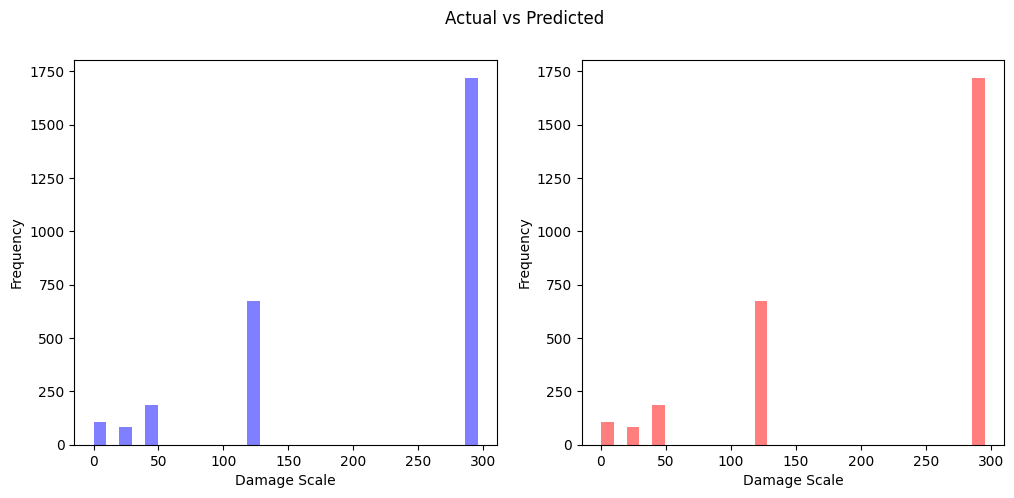

In [5]:
# 모델 예측값과 y 레이블의 정답값 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 예측값과 실제값의 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Actual vs Predicted')

# y_test 히스토그램
axs[0].hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
axs[0].set_xlabel('Damage Scale')
axs[0].set_ylabel('Frequency')

# lr_pred, ridge_pred, lasso_pred, enet_pred, dt_pred, rf_pred
# y_pred_lgb 히스토그램
axs[1].hist(lr_pred, bins=30, alpha=0.5, color='red', label='Predicted')
axs[1].set_xlabel('Damage Scale')
axs[1].set_ylabel('Frequency')

plt.show()



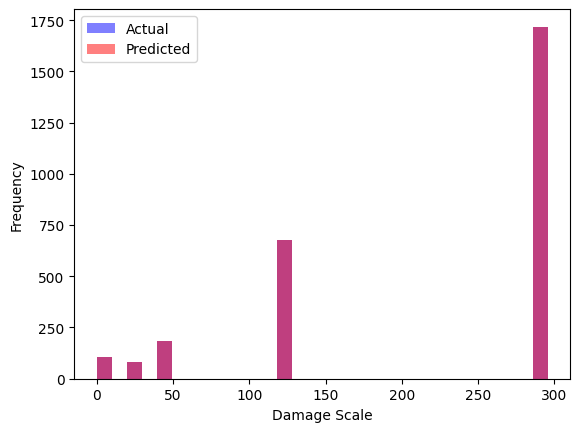

In [6]:
fig, ax = plt.subplots()
ax.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
ax.hist(lr_pred, bins=30, alpha=0.5, color='red', label='Predicted')
ax.set_xlabel('Damage Scale')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

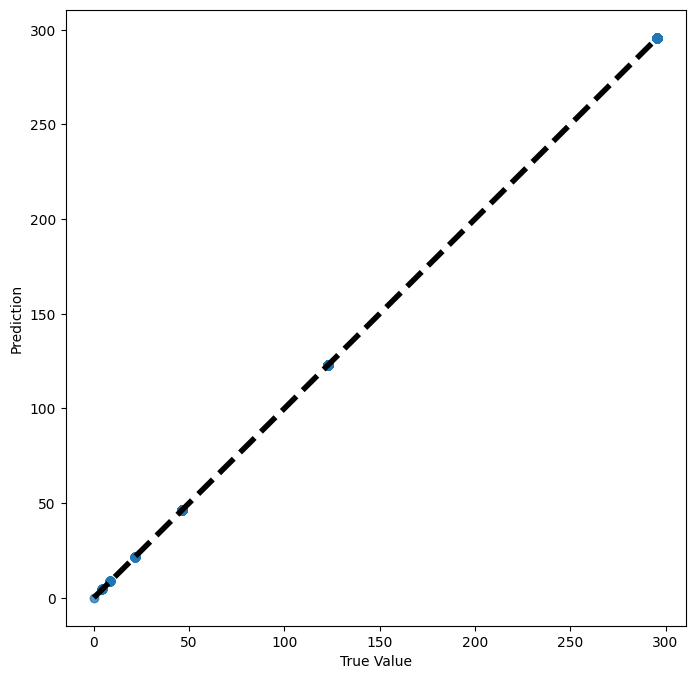

In [7]:
import matplotlib.pyplot as plt

predictions = lr_pred

# 예측값과 실제값 비교
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [predictions.min(), predictions.max()], 'k--', lw=4)
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

predictions = dt_pred

# y_test: 실제 값, prediction: 예측 값
accuracy = np.sum(np.abs(y_test['피해규모'].values - predictions) <= 0.1) / len(y_test)

print("Accuracy: {:.2f}%".format(accuracy * 100))

KeyError: '피해규모'